In [102]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torch.optim as optim
import torch.nn.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Dict
import os

In [103]:
class TextPreprocess:
    def __init__(self):
        self.letter_list = ['<sos>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 
               'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-', "'", '.', '_', '+', ' ', '<eos>']
    
    def transform_letter_to_index(self, raw_transcript):
        output = []
        for transcript in raw_transcript:
            temp = [self.letter_list.index(j) for j in transcript]
            output.append(temp)
        return output
    

    def create_dictionaries(self):
        '''
        Create dictionaries for letter2index and index2letter transformations
        '''
        numbers=np.arange(len(self.letter_list))
        letter2index={self.letter_list[i]: numbers[i] for i in range(0, len(self.letter_list))} 
        index2letter={numbers[i]: self.letter_list[i] for i in range(0, len(self.letter_list))} 
        return letter2index, index2letter

In [104]:
# Load TOY DATASET for attention map 
train_data = np.load("C:\\Users\\thopa\\Desktop\\Assignments\\11685\\HW4\\2022Implementation\\2021_ToySet\\train.npz", allow_pickle=True, encoding='bytes')['data']
dev_data = np.load("C:\\Users\\thopa\\Desktop\\Assignments\\11685\\HW4\\2022Implementation\\2021_ToySet\\dev.npz",  allow_pickle=True, encoding='bytes')['data']

# Load the training, validation raw text transcripts
train_labels = np.load("C:\\Users\\thopa\\Desktop\\Assignments\\11685\\HW4\\2022Implementation\\2021_ToySet\\train_transcripts.npz", allow_pickle=True,encoding='bytes')
dev_labels = np.load("C:\\Users\\thopa\\Desktop\\Assignments\\11685\\HW4\\2022Implementation\\2021_ToySet\\dev_transcripts.npz",  allow_pickle=True,encoding='bytes')

textprocess= TextPreprocess()
# Convert the raw text transcripts to indices 
train_labelIDX = textprocess.transform_letter_to_index(train_labels['data'])
val_labelIDX =  textprocess.transform_letter_to_index(dev_labels['data'])

print("Training Points: {}, Val Points {}".format(len(train_labelIDX), len(val_labelIDX)))

letter2index, index2letter = textprocess.create_dictionaries()

Training Points: 10000, Val Points 100


In [105]:
# Building attention map with toy dataset 
class MelVectorDataset(Dataset):
    def __init__(self, X, Y, val = False):

        # X : Mel Features , Y : Mel Labels 
        self.X, self.Y = X, Y 
        self.val = val
    
    def __len__(self):
    
        return self.X.shape[0]
    
    def __getitem__(self, index):
        if self.val: 
            return torch.as_tensor(self.X[index])
        else: 
            return torch.as_tensor(self.X[index]), torch.as_tensor(self.Y[index])

#Collate function for uniform padding of the input sequences 

def collate_train_val(data): 
    
    (xx, yy) = zip(*data)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]

    xx_pad = pad_sequence(xx,batch_first=True)
    yy_pad = pad_sequence(yy,batch_first=True)

    x_lens = np.asarray(x_lens)
    y_lens = np.asarray(y_lens)
    # Some augmentation and masking here may help the network converge better. 

        
    return xx_pad, yy_pad, torch.tensor(x_lens), torch.tensor(y_lens)



In [106]:
# Datasets for train and validation 
train_dataset = MelVectorDataset(train_data, train_labelIDX, val = False)
val_dataset = MelVectorDataset(dev_data, val_labelIDX, val = True)


# Dataloader with collate functionality
train_loader = DataLoader(train_dataset, collate_fn= collate_train_val , batch_size= 64, shuffle= True)
val_loader = DataLoader(val_dataset, collate_fn= collate_train_val, batch_size= 64, shuffle= False)


In [107]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, key_value_size):
        super(Encoder, self).__init__()

        self.BiLSTM = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = 3, bidirectional = True)
        self.key = nn.Linear(hidden_dim*2, key_value_size)
        self.value = nn.Linear(hidden_dim*2, key_value_size)
    
    def forward(self, input, input_len):
        
        # To save the number of computations since we are padding zeros 
        input = rnn_utils.pack_padded_sequence(input, lengths = input_len.cpu(), batch_first= True, enforce_sorted= False)
        rnn_out, _ = self.BiLSTM(input)
        output, lens = rnn_utils.pad_packed_sequence(rnn_out, batch_first= True)
        key = self.key(output)
        value = self.value(output)
        
        return key, value, lens

In [108]:
# Attention block 
"""
Possible Efficiencies with the attention mechanism (d2l book)
1) In general, it requires that both the query and the key have the 
same vector length, say d, even though this can be addressed easily by replacing 
q⊤k with q⊤Mk where M is a suitably chosen matrix to translate
between both spaces. For now assume that the dimensions match.
2) Adding dropout weights also helps 
"""
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
    
    def forward(self, query, key, value, mask):
        energy = torch.bmm(key, query.unsqueeze(2))
        energy = torch.squeeze(energy, dim = 2)

        #What should the mask least value be? 
        energy.masked_fill_(mask, -1e9)

        attention = torch.nn.functional.softmax(energy, dim = 1)
        context = torch.bmm(attention.unsqueeze(1), value)
        
        return context, attention

In [109]:
# Decoder ~ according to the speller of the LAS paper 

class Decoder(nn.Module):
    def __init__(self, embed_dim, key_value_size, vocab_size):
        super(Decoder, self).__init__()
        
        """
        A simple lookup table that stores embeddings of a fixed dictionary and size.
        This module is often used to store word embeddings and retrieve them using indices. 
        The input to the module is a list of indices, and the output is the corresponding word embeddings.
        """
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx = 0 ).cuda()
        self.lstm1 = nn.LSTMCell(embed_dim + key_value_size , key_value_size)
        self.vocab_size = vocab_size
        self.attention = Attention()
        self.character_prob = nn.Linear(2*key_value_size, vocab_size)
        self.key_value_size = key_value_size
        self.device = "cuda"
        
    def forward(self, key, value, encoder_len, y = None, mode = "train", teacherForcingRate = 0.1, isGumbel = False ):
        
        batch, key_seq_max_len, key_value_size = key.shape


        # Attention mask for making the system autoregressive 
        mask = torch.arange(key_seq_max_len).unsqueeze(0)>=encoder_len.unsqueeze(1)
        mask = mask.to(self.device)

        # List to store output attention plots 
        predictions, attention_plot = [], []
        prediction = torch.full((batch,1), fill_value= 0 ,device= self.device)

        # Hidden states
        hidden_state= [None, None]
        context = value[:,0,:]

        if mode == "train":
            max_len = y.shape[1]
            char_embedding = self.embedding(y)
        else: 
            max_len = 300

        for i in range(max_len):
            if mode == "train":
                # Teacher Forcing regime ~ Assigned and picked randomly 
                teacher_forcing = True if random.random() > teacherForcingRate else False 
                if not teacher_forcing:
                    if i != 0 : # use Gumbel noise to add noise to add variety to phoneme
                        char_embed = torch.nn.functional.gumbel_softmax(prediction).mm(self.embedding.weight)
                    else:
                        char_embed = self.embedding(prediction.argmax(dim=-1))
                else:
                    if i == 0:
                        char_embed = self.embedding(torch.zeros(batch, dtype = torch.long).fill_(letter2index['<sos>']).to(self.device)) 
                    else: 
                        char_embed = char_embedding[:,i-1,:] # ground truth teacher forcing 
            # Validation mode 
            else: 
                if i == 0: 
                    char_embed = self.embedding(torch.zeros(batch, dtype = torch.long).fill_(letter2index['<sos>']).to(self.device)) 
                else: 
                    char_embed = self.embedding(prediction.argmax(dim = -1)) # feed in the previous prediction as input 
            
            # Input to the decoder (prev embedding + context from attention mechanism) 
            y_context = torch.cat([char_embed, context.squeeze(1)], dim = 1)
            hidden_state[0] = self.lstm1(y_context, hidden_state[0])

            # What is the query? (same len as the key)
            # Hidden state of the LSTM 
            query = hidden_state[0][0]
            context, attention = self.attention(query, key, value, mask)
            attention_plot.append(attention[0].detach().cpu())

            output_context = torch.cat([query, context.squeeze(1)], dim = 1)
            prediction = self.character_prob(output_context)
            predictions.append(prediction.unsqueeze(1))
        attentions = torch.stack(attention_plot, dim = 0)
        predictions = torch.cat(predictions, dim = 1 )

        return predictions, attentions

In [110]:
class Seq2Seq(nn.Module):
    def __init__(self, input_dim, encoder_hidden_dim, vocab_size, embed_dim, key_value_size = 128):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_dim = input_dim, hidden_dim = encoder_hidden_dim, key_value_size = key_value_size )
        self.decoder = Decoder(vocab_size = vocab_size, embed_dim = embed_dim, key_value_size= key_value_size)
    
    def forward(self, x, x_len, y = None, mode = "train", isTrain = True):
        key, value, encoder_len = self.encoder(x, x_len)
        predictions, attentions = self.decoder(key, value, encoder_len, y, mode)

        return predictions, attentions

In [111]:
seq2seq_model = Seq2Seq(input_dim = 40,vocab_size = 34, encoder_hidden_dim = 128, embed_dim = 128)
model=seq2seq_model.cuda()

# Some other hyperparameter 
optimizer = optim.Adam(model.parameters(), lr= 2e-3)

"""
This criterion computes the cross entropy loss between input logits and target.

It is useful when training a classification problem with C classes. 
If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. 
This is particularly useful when you have an unbalanced training set.

"""
criterion = nn.CrossEntropyLoss(reduction = 'none')

In [99]:
"""
Attention map plotting 

"""
def plot_attention(attention, idx):
    # utility function for debugging
    path = "C:\\Users\\thopa\\Desktop\\Assignments\\11685\\HW4\\2022Implementation\\code\\results\\"
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.savefig("{}_attn.png".format(path + idx))

C:\Users\thopa\AppData\Local\Temp\ipykernel_24280\3637603455.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_len = torch.max(torch.tensor(label_len))


Epoch[0/20] Training Loss: 3.2331273555755615
Epoch[1/20] Training Loss: 3.2097597122192383
Epoch[2/20] Training Loss: 3.2013869285583496
Epoch[3/20] Training Loss: 3.1652865409851074
Epoch[4/20] Training Loss: 2.9352993965148926
Epoch[5/20] Training Loss: 2.557483673095703
Epoch[6/20] Training Loss: 2.2713112831115723
Epoch[7/20] Training Loss: 2.734706163406372
Epoch[8/20] Training Loss: 2.70078706741333
Epoch[9/20] Training Loss: 2.5099875926971436
Epoch[10/20] Training Loss: 2.654869556427002
Epoch[11/20] Training Loss: 2.8881139755249023
Epoch[12/20] Training Loss: 3.0763747692108154
Epoch[13/20] Training Loss: 2.839353561401367
Epoch[14/20] Training Loss: 2.949983596801758


KeyboardInterrupt: 

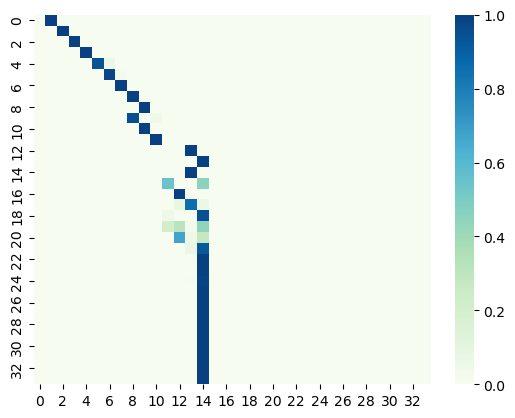

In [100]:
# Training sequence 
epochs = 20
device = 'cuda'
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for i,(data,label, data_len, label_len) in enumerate(train_loader):

        # Avoid gradient accumulation
        optimizer.zero_grad()
        data, datalen, label, label_len = data.to(device), data_len, label.to(device), label_len
        pred, attn = model(x = data, x_len = datalen, y = label, mode = "train")

        # Dealing with masking and masking loss etc.
        max_len = torch.max(torch.tensor(label_len))
        lst = torch.arange(0,max_len).repeat(label_len.size(0),1)
  
        seq_len = label_len.unsqueeze(1).expand(label_len.size(0),max_len)
        mask = (lst<seq_len).int().cuda() 
        loss = criterion(pred.view(-1, pred.size(2)), label.view(-1))
        masked_loss = torch.sum(loss * mask.view(-1)) / torch.sum(mask)

        masked_loss.backward()
        running_loss+=masked_loss
        optimizer.step()
        idx = "{}_{}".format(epoch, i)
        plot_attention(attn,idx)

    print("Epoch[{}/{}] Training Loss: {}".format(epoch, epochs, running_loss/len(train_loader)))
    torch.save({'train_loss_history': running_loss,'optimizer_state_dict': optimizer.state_dict(), 'model_state_dict' : model.state_dict()}, os.path.join("C:\\Users\\thopa\\Desktop\\Assignments\\11685\\HW4\\2022Implementation\\code\\ckpt", 'seq2seq_epoch_{}.pth'.format(epoch)))


In [112]:
import imageio
import glob 

images = []
filenames = "C:\\Users\\thopa\\Desktop\\Assignments\\11685\\HW4\\2022Implementation\\code\\results\\*.png"
out = "C:\\Users\\thopa\\Desktop\\Assignments\\11685\\HW4\\2022Implementation\\code\\gifs\\"
for filename in sorted(glob.glob(filenames)):
    images.append(imageio.imread(filename))
imageio.mimsave('{}\\attention.gif'.format( out), images)

C:\Users\thopa\AppData\Local\Temp\ipykernel_24280\3324046309.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
